In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import sys
sys.path.insert(0, '..')

from MES_LSTM.model import *
from utils.metrics import *

import warnings
warnings.simplefilter('ignore')

# check version
print(tf.keras.__version__)
print(tf.__version__)
print(tfp.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))



2.4.0
2.4.1
0.12.2
0


In [2]:
pre_layer = preprocess(first_time = 0) # change first time to 1 if first time running to download data
df = pre_layer.load_data()
df = pre_layer.clean_data(df)
df = pre_layer.fill_missing(df)
scaled_df, df_scaler = pre_layer.scale(df)
scaled_df

[INFO] data cleaned
[INFO] the dataframe has 30 columns in total and 17 columns that have missing values.
                                      Missing Values  % of Total Values
weekly_icu_admissions                            602              100.0
handwashing_facilities                           602              100.0
total_boosters                                   602              100.0
weekly_hosp_admissions                           524               87.0
excess_mortality                                 519               86.2
excess_mortality_cumulative                      519               86.2
excess_mortality_cumulative_absolute             519               86.2
people_fully_vaccinated                          346               57.5
people_vaccinated                                342               56.8
total_vaccinations                               342               56.8
positive_rate                                     68               11.3
icu_patients                  

,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,1.000000,1.217374,1.560067,1.317521,1.319698,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-01,1.000000,1.217374,1.560067,1.317521,1.319698,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-02,1.000000,1.217573,1.546132,1.316465,1.318657,1.000240,1.016112,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-03,1.000001,1.217574,1.546131,1.316465,1.318657,1.000241,1.016112,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-02-04,1.000001,1.217574,1.546131,1.316465,1.318657,1.000241,1.016112,1.034911,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,1.982003,1.995468,1.184300,1.326608,1.287632,1.977614,1.261524,1.375466,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-20,1.986731,1.995836,1.194539,1.327046,1.288692,1.981167,1.263847,1.371141,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-21,1.990834,1.997334,1.197952,1.321787,1.289752,1.984339,1.266169,1.375041,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09-22,1.995284,1.998568,1.250239,1.313241,1.285760,1.987796,1.268491,1.354438,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:
mes_layer = ES()
params, internals = mes_layer.es(scaled_df)
es_scaled, df_trend, df_seas = mes_layer.deTS(scaled_df, internals)

es_scaled

[INFO] internals loaded


,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,-7.157292e-07,8.471244e-06,-7.718270e-13,-0.000741,0.000022,2.220446e-16,5.773160e-15,3.708145e-14,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10,7.269836e-10
2020-02-01,6.592583e-07,5.727707e-06,-2.106093e-13,-0.000116,0.000061,-1.110223e-16,-3.711476e-13,-9.752199e-13,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09,1.450322e-09
2020-02-02,5.138950e-07,9.798602e-06,-1.243365e-10,0.000206,-0.000453,-1.110223e-15,1.713907e-12,5.270340e-12,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09,2.170043e-09
2020-02-03,1.728883e-07,8.590779e-06,1.272759e-10,0.000144,-0.000712,-1.554312e-15,-4.712342e-13,-1.673550e-12,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09,2.886164e-09
2020-02-04,1.744239e-08,1.382308e-06,-5.756062e-12,0.000416,0.000296,1.776357e-15,-6.127876e-13,-1.975864e-12,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09,3.598703e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,1.519281e-07,-9.464338e-07,-2.982703e-11,0.000027,-0.001551,2.942091e-15,1.421085e-13,-1.027622e-12,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07,1.342314e-07
2021-09-20,4.403140e-06,-8.491004e-07,-2.853884e-11,0.000469,-0.000604,1.831868e-15,4.966028e-13,1.081912e-12,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07,1.342559e-07
2021-09-21,-2.381205e-06,-1.796756e-06,-6.706374e-11,-0.000641,0.000633,3.885781e-15,2.833289e-13,1.721068e-12,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07,1.342803e-07
2021-09-22,4.110367e-07,-3.208378e-06,4.346031e-10,-0.001534,0.000039,-2.220446e-16,5.951351e-13,-2.820966e-12,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07,1.343045e-07


[INFO] data shape: train = (542, 20), valid = (15, 20), test = (45, 20), x_train = (542, 18), y_train = (542, 2), x_valid = (15, 18), y_valid = (15, 2), x_test = (45, 18)


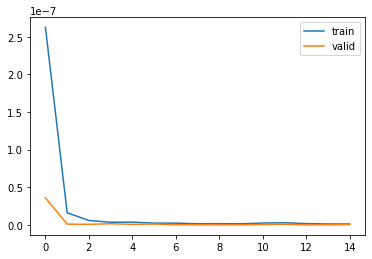

In [4]:
dl_layer = lstm()
train, valid, test, x_train, y_train, x_valid, y_valid, x_test = dl_layer.split(es_scaled)
y_pred_es_scaled = dl_layer.forecast_model(test, x_train, y_train, x_valid, y_valid, x_test)

[INFO] forecasts saved in results folder


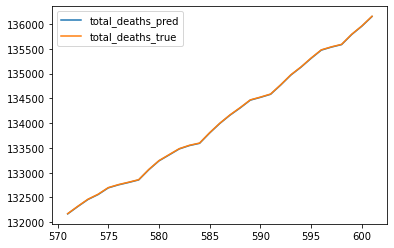

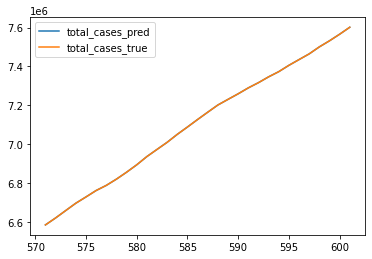

In [5]:
forecasts = dl_layer.reTS(y_pred_es_scaled, es_scaled, train, valid, df_trend, df_seas, df_scaler, df)

### prediction intervals

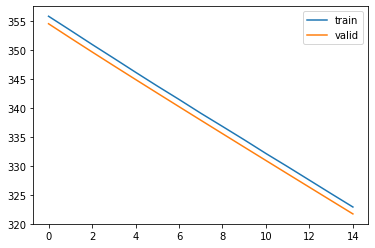

[INFO] prediction intervals computed


In [6]:
pi_pred_es_scaled = dl_layer.pi_model(test, x_train, y_train, x_valid, y_valid, x_test)

[INFO] prediction intervals saved in results folder


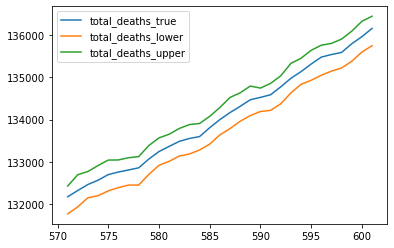

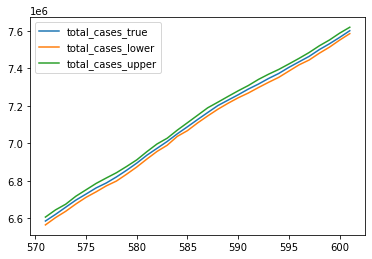

In [7]:
pi = dl_layer.reTS_pi(pi_pred_es_scaled, es_scaled, train, valid, df_trend, df_seas, df_scaler, df)

In [8]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

673.6719978444744
39717.48055360737


In [9]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

100.0
100.0


In [10]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

0.004125188371994963
0.00030245742148854546


In [11]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

5.561269321834791
25.956937009903697


# RNN

[INFO] data shape: train = (542, 20), valid = (15, 20), test = (45, 20), x_train = (542, 18), y_train = (542, 2), x_valid = (15, 18), y_valid = (15, 2), x_test = (45, 18)


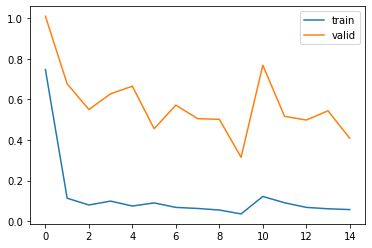

[INFO] forecasts saved in results folder


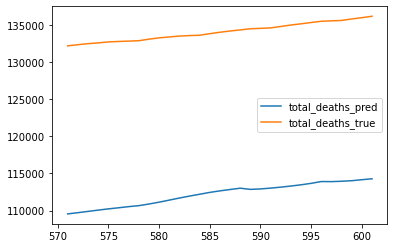

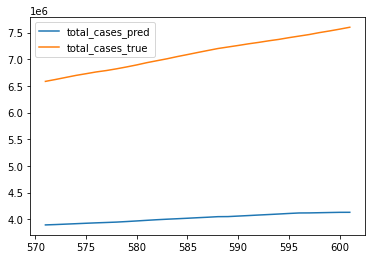

In [12]:
dl_layer = lstm(results_path = 'results/pure_lstm/')
train, valid, test, x_train, y_train, x_valid, y_valid, x_test = dl_layer.split(scaled_df)
y_pred_scaled = dl_layer.forecast_model(test, x_train, y_train, x_valid, y_valid, x_test)

forecasts = dl_layer.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)

### prediction intervals

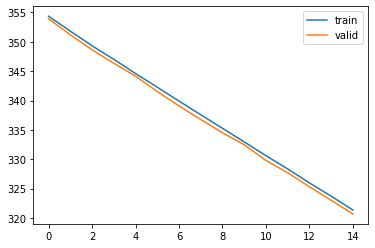

[INFO] prediction intervals computed
[INFO] prediction intervals saved in results folder


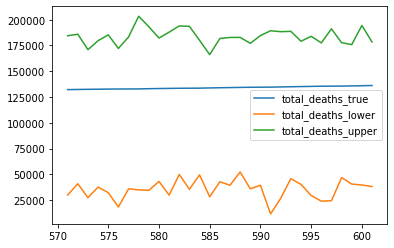

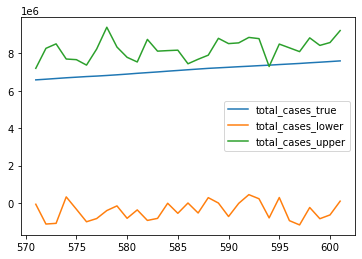

In [13]:
pi_pred_scaled = dl_layer.pi_model(test, x_train, y_train, x_valid, y_valid, x_test)

pi = dl_layer.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [14]:
pi.head()

,total_deaths_true,total_deaths_lower,total_cases_lower,total_cases_true,total_deaths_upper,total_cases_upper
571,132174.0,29863.150746,-7.002997e+04,6586181.0,184446.015952,7.204362e+06
572,132323.0,40820.710021,-1.128914e+06,6621799.0,185945.806823,8.273935e+06
573,132465.0,27283.152622,-1.091140e+06,6659916.0,170932.170334,8.513017e+06
574,132566.0,37560.034931,3.240126e+05,6697770.0,179701.739543,7.702123e+06
575,132699.0,32216.383962,-3.352362e+05,6729912.0,185338.251869,7.667526e+06


In [15]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

148160.83830441686
8690584.943018656


In [16]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

100.0
96.7741935483871


In [17]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

17.76616812646498
55.3477445795475


In [18]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

21870.96070627601
3092320.904294701


# VARMAX

[INFO] data shape: train = (542, 20), test = (60, 20), x_train = (542, 18), y_train = (542, 2), x_test = (60, 18)
[INFO] VARMAX fitting complete
[INFO] forecasts saved in results folder
[INFO] prediction intervals saved in results folder


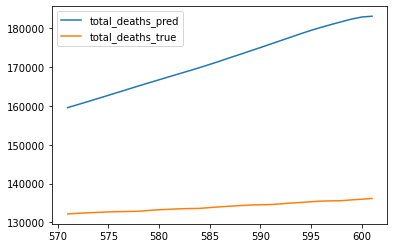

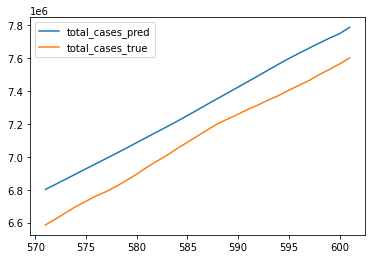

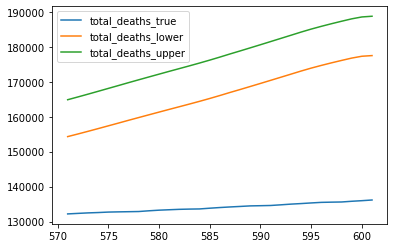

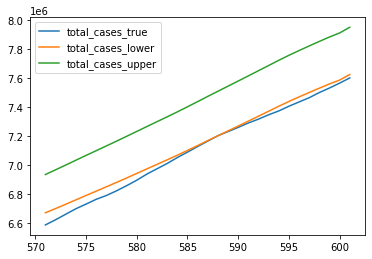

In [19]:
bench = stats()
train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_varmax(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [20]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

654639.9577045118
987850.9892651326


In [21]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
3.225806451612903


In [22]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

24.54498602696442
2.573456646092853


In [23]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

38166.295585130145
185408.84553156936


# SARIMAX

[INFO] SARIMAX fitting complete
[INFO] forecasts saved in results folder
[INFO] prediction intervals saved in results folder


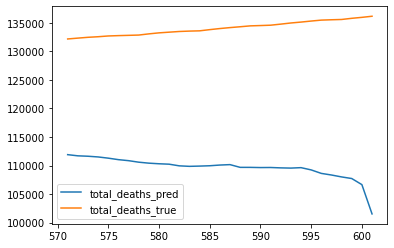

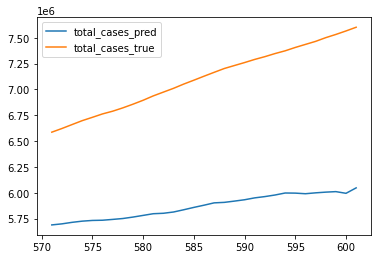

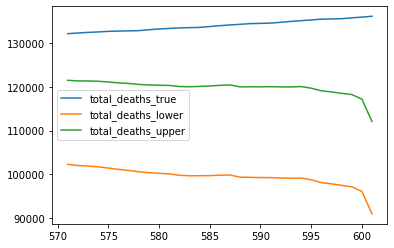

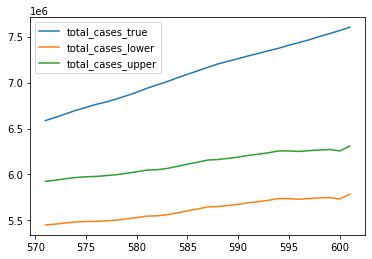

In [24]:
bench = stats(results_path = 'results/sarimax/')
# train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_sarimax(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [25]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

304515.1146705416
20222401.755056698


In [26]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
0.0


In [27]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

20.04409941227178
19.015030469663984


In [28]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

24586.444358463068
1253308.0864053725


# MLR

[INFO] MLR fitting complete
[INFO] forecasts saved in results folder
[INFO] prediction intervals saved in results folder


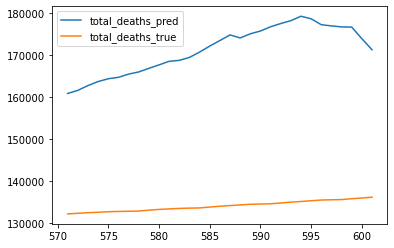

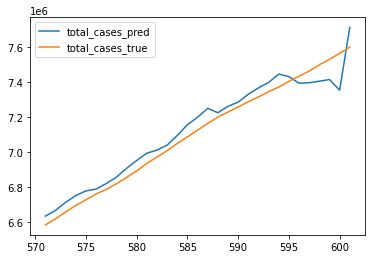

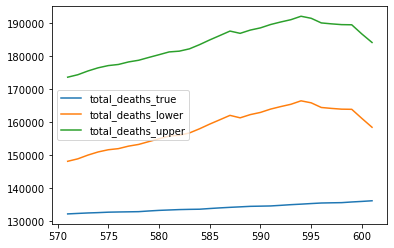

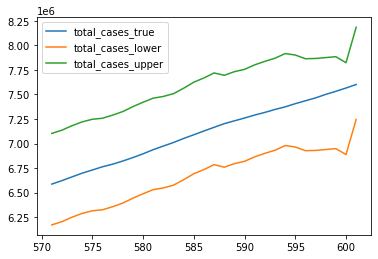

In [29]:
bench = stats(results_path = 'results/mlr/')
# train, test, x_train, x_test = bench.split(scaled_df)
y_pred_scaled, pi_pred_scaled = bench.forecast_mlr(test, x_train, y_train, x_test)
forecasts = bench.descale(y_pred_scaled, scaled_df, train, valid, df_scaler, df)
pi = bench.descale_pi(pi_pred_scaled, scaled_df, train, valid, df_scaler, df)

In [30]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(mis(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values, alpha = dl_layer.alpha))
print(mis(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values, alpha = dl_layer.alpha))

514625.2031949738
935173.9160051565


In [31]:
# print('\n' + 'MIS for MES-RNN:\n', file = f)
print(coverage(pi['total_deaths_lower'].values, pi['total_deaths_upper'].values, pi['total_deaths_true'].values))
print(coverage(pi['total_cases_lower'].values, pi['total_cases_upper'].values, pi['total_cases_true'].values))

0.0
100.0


In [32]:
print(smape(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(smape(forecasts['total_cases_true'], forecasts['total_cases_pred']))

24.333843919464794
0.8312371105755665


In [33]:
print(rmse(forecasts['total_deaths_true'], forecasts['total_deaths_pred']))
print(rmse(forecasts['total_cases_true'], forecasts['total_cases_pred']))

37508.392867965704
69655.48711252416
